In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Gradient Boosting

### Gradient Boosting from Scratch

In [2]:
from sklearn.tree import DecisionTreeRegressor

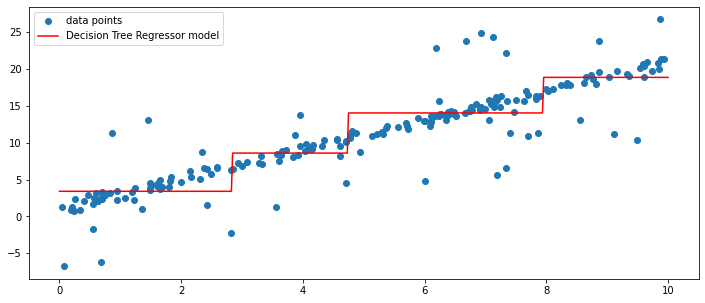

In [3]:
# A 1D regression with decision tree
m = 200
# for x and y, make a line with a bit of noise
x = 10 * np.random.rand(m,1)
y = 2*x + 1 + 0.5*np.random.randn(m,1)
y[::5,:] += 20 * (0.5 - np.random.rand(m//5,1)) # add outliers
y = y.flatten()

# decision tree
reg_tree1 = DecisionTreeRegressor(max_depth=2)
reg_tree1.fit(x,y)

# plot data
plt.figure(figsize=(12,5))
plt.scatter(x,y,label='data points')

# plot model
x_plot = np.linspace(0,10,500).reshape(500,1)
y_plot = reg_tree1.predict(x_plot)

plt.plot(x_plot,y_plot, c='red',label='Decision Tree Regressor model')

plt.legend()

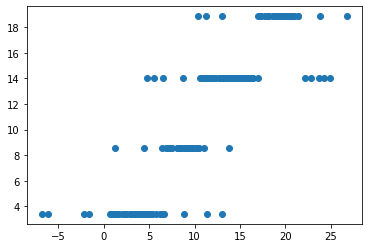

In [8]:
y1_pred = reg_tree1.predict(x)
plt.scatter(y,y1_pred)

Text(0.5, 1.0, 'residuals')

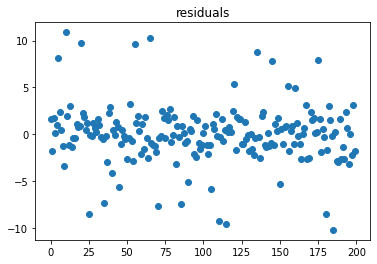

In [9]:
# compute the residuals (difference between actual and predicted values)
y2 = y - y1_pred
plt.plot(y2,'o')
plt.title('residuals')

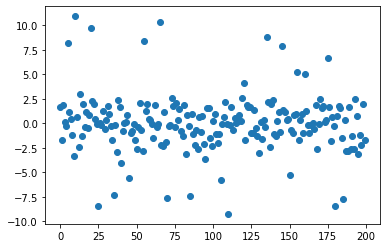

In [10]:
# Fit the new tree on the residuals
reg_tree2 = DecisionTreeRegressor(max_depth=2)
reg_tree2.fit(x,y2)
# compute new residuals
y2_pred = reg_tree2.predict(x)
y3 = y2-y2_pred
plt.plot(y3,'o')

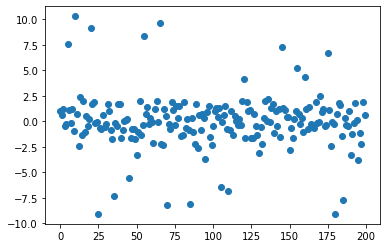

In [11]:
# repeat
reg_tree3 = DecisionTreeRegressor(max_depth=2)
reg_tree3.fit(x,y3)
# compute new residuals
y3_pred = reg_tree3.predict(x)
y4 = y3-y3_pred
plt.plot(y4,'o')

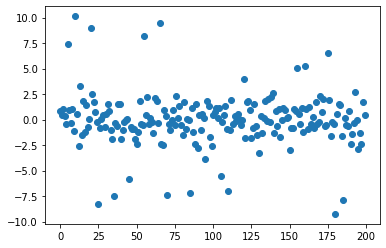

In [12]:
reg_tree4 = DecisionTreeRegressor(max_depth=2)
reg_tree4.fit(x,y4)
# compute new residuals
y4_pred = reg_tree4.predict(x)
y5 = y4-y4_pred
plt.plot(y5,'o')

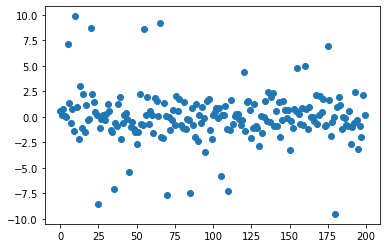

In [13]:
reg_tree5 = DecisionTreeRegressor(max_depth=2)
reg_tree5.fit(x,y5)
# compute new residuals
y5_pred = reg_tree5.predict(x)
y6 = y5-y5_pred
plt.plot(y6,'o')

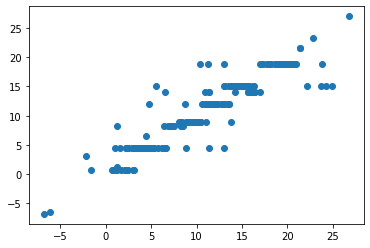

In [14]:
# finalize predictions
y_pred = y1_pred + y2_pred + y3_pred + y4_pred + y5_pred
plt.scatter(y,y_pred)

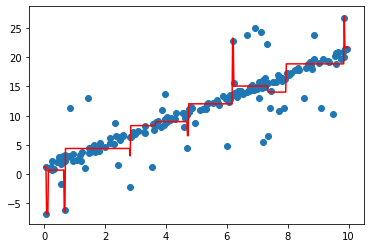

In [15]:
# plot gradient boosting model
y1_plot = reg_tree1.predict(x_plot)
y2_plot = reg_tree2.predict(x_plot)
y3_plot = reg_tree3.predict(x_plot)
y4_plot = reg_tree4.predict(x_plot)
y5_plot = reg_tree5.predict(x_plot)
y_plot = y1_plot + y2_plot + y3_plot + y4_plot + y5_plot

plt.scatter(x,y)
plt.plot(x_plot,y_plot,'r')

## Building a gradient boosting model in scikit-learn

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

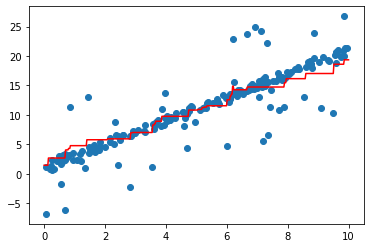

In [44]:
gb_reg = GradientBoostingRegressor(n_estimators=100,max_depth=2,learning_rate=0.02)
gb_reg.fit(x,y)
y_plot = gb_reg.predict(x_plot)
plt.scatter(x,y) # plot original points
plt.plot(x_plot,y_plot,color='red') # plot predicted values

## as n_estimators, the number of trees, goes up, learning_rate should go down.

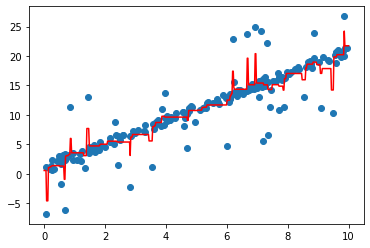

In [18]:

gb_reg = GradientBoostingRegressor(n_estimators=100,max_depth=2,learning_rate=0.1)
gb_reg.fit(x,y)
y_plot = gb_reg.predict(x_plot)
plt.scatter(x,y)
plt.plot(x_plot,y_plot,color='red')

# Fremont Bridge Data. Broken

In [ ]:
# load  traffic, weather, and air quality index datasets
fremont = pd.read_csv('../Linear Regression/Fremont_Bridge_Bicycle_Counter.csv',index_col='Date',parse_dates=True).resample('d').sum()
weather = pd.read_csv('../Linear Regression/seattle_weather.csv',index_col='DATE',parse_dates=True)
aqi = pd.read_csv('../Linear Regression/Seattle_air_quality_index.csv',index_col='Date',parse_dates=True)


In [53]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

In [60]:


# add day of the week/month/year/covid columns
fremont['day_of_week'] = fremont.index.dayofweek
fremont['month'] = fremont.index.month
fremont['year'] = fremont.index.year
fremont['covid'] = 0
fremont.loc['03-01-2020':,'covid'] = 1

# add holidays column
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays('01-01-2013','09-30-2022')
fremont['holidays'] = pd.Series(1,index=holidays,name='holidays')
fremont.fillna(0,inplace=True)

# add hours of daylight column
def get_hoursdaylight(date):
    axis = np.radians(23.44) # tilt of Earth's axis
    latitude = np.radians(47.61) # Seattle's latidude 
    days = (date-pd.to_datetime('2000-12-31')).days
    m = (1 - np.tan(latitude)*np.tan(axis*np.cos(days*2*np.pi/365.25)))
    return 24*np.degrees(np.arccos(1-m))/180
fremont['hours_daylight'] = fremont.index.map(get_hoursdaylight)

# fix TAVG column
weather.TAVG.fillna(0.5*(weather.TMAX+weather.TMIN),inplace=True)

# join weather and traffic datasets
fremont = fremont.join(weather[['PRCP','TAVG','SNOW','AWND']]).loc['2013-01-01':]

# add air quality index
fremont['aqi'] = aqi

# fix aqi missing values
fremont.fillna(method='ffill',inplace=True)
# 2013-2020
fremont2013_2020 = fremont[fremont.index.year<2021].copy()
# 2020-2022
fremont2021_2022 = fremont[fremont.index.year>=2021].copy()

# target vector / feature matrix
y2013_2020 = fremont2013_2020['Fremont Bridge Total']
X2013_2020 = fremont2013_2020[['day_of_week','covid','holidays','hours_daylight','PRCP','TAVG','SNOW','AWND','year','aqi']]

X2021_2022 = fremont2021_2022[['day_of_week','covid','holidays','hours_daylight','year','PRCP','TAVG','SNOW','AWND','aqi']]
y2021_2022 = fremont2021_2022['Fremont Bridge Total']


ValueError: columns overlap but no suffix specified: Index(['PRCP', 'TAVG', 'SNOW', 'AWND'], dtype='object')

In [57]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures

In [58]:
num_features = ['hours_daylight','PRCP','TAVG','SNOW','AWND','year','aqi']
cat_features = ['day_of_week','covid','holidays']

In [59]:
feature_processor = ColumnTransformer(transformers=[
    ('encoder',OneHotEncoder(handle_unknown='ignore'),cat_features),
],remainder='passthrough')

# regression pipeline
pipe = Pipeline(steps=[
    ('feature_processor',feature_processor),
    ('scaler', MinMaxScaler()),
    ('poly_features',PolynomialFeatures(degree=2)),
    ('regressor',Ridge(alpha=1)) #  Rige, Lasso or LinearRegression
])
pipe.fit(X2013_2020,y2013_2020)
fremont2013_2020['predicted'] = pipe.predict(X2013_2020)
fremont2013_2020.plot.scatter(x='Fremont Bridge Total',y='predicted')
plt.plot([0,6000],[0,6000],'r--')
plt.title('daily traffic, 2013-2020')

NameError: name 'X2013_2020' is not defined

In [ ]:
# grid search
param_dic = {
    'regressor__max_depth': [2,5,8],
    'regressor__n_estimators': [10,50,100,200,500],
    'regressor__learning_rate': [0.001,0.01,0.1,0.5,1]
}

grid = GridSearchCV(pipe,
                    param_dic,
                    cv=10,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=true
                   )
grid.fit(X2013_2020,y2013_2020)